## Assignment 8
The goal of this lab is to examine and experiment with several techniques related to influence analysis
in complex networks. Influence is defined between two users and represents how
possible is for a user to adapt the behavior or copy the action of another user. 

We will first introduce the diffusion model which can be used to simulate a spreading process that takes place over the network.
 
Subsequently, we will utilize the structure of the network to identify influencers based in a heuristic manner.

Finally, we will examine the algorithmic solution to the problem of influence maximization,
which is choosing the optimum nodes to maximize the spread of information, and compare it with
the heuristic approach based on the simulations.

We will again rely on the network sciecne dataset for our use case. The following questions can be answered with the help of networkx and NDlib. You may also use other packages to deal with the problem. Please answer the following questions on the networks you have and submit your executable code.

In [1]:
path = "/Users/0232112159/Desktop/Complex Analysis"

In [2]:
# download a file from a url 
import requests

def download(url,file_name):
    get_response = requests.get(url)
    with open(file_name, "wb") as out_file:
        out_file.write(get_response.content)

download(url = "http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name=path+"netscience.gml")

/Users/0232112159/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
import networkx as nx

# Read the data and show the basic information

# Load the GML file
gml_file_path = path + "netscience.gml"
G = nx.read_gml(gml_file_path)

print("Graph Info:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed: {G.is_directed()}")

Graph Info:
Number of nodes: 1589
Number of edges: 2742
Is directed: False


**(a)** We will first create a method to evaluate our chosen seeds, based on epidemic simulation. As a means for evaluation, we use the Independent Cascade model, to compute the number of influenced nodes during an influence spread over the network. 
This model assumes that a node v has only one chance to influence each of its neighbors u based on the probability `p v,u` . 
We define the model's parameters (threshold=0.01) based on common approaches in the literature, and run the epidemic through 10 steps in order to get an approximation and retreive fast results (in normal circumstances it is 10 thousand).


In terms of implementation we will define a function $simulate\_spreading$ that performs the simulation using the IndependentCascadeModel and ModelConfig from NDlib.
More specficially, we have to loop through the edges and add a variable named "threshold" that resembles the probability of influencing a node's neighbors (set to $0.01$ as is common in the literature for dense graphs), using the function $add\_edge\_configuration$.


In [10]:
import networkx as nx
import random

def simulate_spreading(G,seed_set,sim=10,num_steps=5,threshold = 0.01):
    """
    Given the graph and the seed set, compute the number of infected nodes after the end of a spreading process
     
    Parameters:
    G (networkx.Graph): The network graph
    seed_set (set): Set of initial infected nodes
    sim (int): Number of simulations to run
    num_steps (int): Number of steps for each simulation
    threshold (float): Probability threshold for infection
    
    Returns:
    float: Average number of infected nodes across all simulations
    """
    total_infected = 0
    for _ in range(sim):
        infected = set(seed_set)
        new_infected = set(seed_set)
        
        for _ in range(num_steps):
            current_new_infected = set()
            
            for node in new_infected:
                
                for neighbor in G.neighbors(node):
                    if neighbor not in infected:
                        if random.random() < threshold:
                            current_new_infected.add(neighbor) 
                            
       
            infected.update(current_new_infected)
            newly_infected = current_new_infected
            
            if not newly_infected:
                break
        
        total_infected += len(infected)
    
    average_infected = total_infected / sim
    return average_infected




**(b)** Compute K-core score:  Given our undirected network G, C k is defined as the k-core subgraph of G if it is a maximal connected subgraph in which all nodes have degree at least k. Then, each node v ∈ V has a core number c(v) = k, if it belongs to a k-core but not to a (k + 1)-core. The cohesion of subgraphs increases as k increases. Let us denote as C the set of nodes with the maximum core number k\_max. Compute the top 20 nodes in terms of the k-core they belong to and simulate their spreading.

In [12]:
from collections import Counter

def compute_kcore_and_simulate_spreading(G, top_nodes = 20):
    #core numbers for all nodes 
    core_numbers = nx.core_number(G)
    
    #Find maximum core number 
    k_max = max(core_numbers.values())
    
    #sort nodes  in descending order by core number
    sorted_nodes = sorted(core_numbers.items(), key = lambda x:x[1], reverse = True)
    
    #Get the top 20 nodes 
    top_20_nodes = [node for node, _ in sorted_nodes [:top_nodes]]
    
    print (f" Maximum core number (k_max): {k_max}")
    print(f"Top 20 nodes by core number: {top_20_nodes}")
    
    #Simulate spreading using the top 20 nodes as seeds
    seed_set = set(top_20_nodes)
    influenced_nodes = simulate_spreading(G, seed_set)
    
    print(f"Number of influenced nodes : {influenced_nodes}")
    
    return top_20_nodes, influenced_nodes

top_20_nodes, influenced_nodes = compute_kcore_and_simulate_spreading(G)

 Maximum core number (k_max): 19
Top 20 nodes by core number: ['GIOT, L', 'UETZ, P', 'CAGNEY, G', 'MANSFIELD, T', 'JUDSON, R', 'KNIGHT, J', 'LOCKSHON, D', 'NARAYAN, V', 'SRINIVASAN, M', 'POCHART, P', 'QURESHIEMILI, A', 'LI, Y', 'GODWIN, B', 'CONOVER, D', 'KALBFLEISCH, T', 'VIJAYADAMODAR, G', 'YANG, M', 'JOHNSTON, M', 'FIELDS, S', 'ROTHBERG, J']
Number of influenced nodes : 20.0


**(c)** Implement Greedy IM: Influence Maximization is the problem that lies in the heart of influence analysis and addresses how to find a set of nodes, such that if they start a diffusion, the number of infected nodes in the network (influenced spread) will be maximized. It has a broad range of applications, from viral marketing, which was the initial motivation for the problem, to epidemiological containment and political campaign management.
The problem can be formulated as follows: given a social network, a diffusion model with some parameters and a number k, find a seed set S $\subset$ V of size k such that the influence spread is maximized.  We will use the well known method from Kempe et al.[ [1](https://dl.acm.org/doi/pdf/10.1145/956750.956769?casa_token=tkl-2BIJoXIAAAAA:SD8O7LcvEPGyGAdv8cHEwSqgn3Jz0UeHvpRK3-xYB2Z9C7gy-iOQpeHoFqOWzDMfAskBgVzYrpzS)] that is based on the fact that the function of the influence spread under the IC and LT models is monotone non-decreasing and submodular, which gives a  $(1-1/e)$ approximation ratio to the optimal.

To simplify and speed up the implementation to less then a minute, we are going to use only one simple simulation based on the function defined above. Moreover, we will reduce the search space of the algorithm by giving as an input a set of selected nodes to search on. To find a shorter set of such nodes, you can use the filter\_graph function below, that removes nodes under a certain degree, and set an appropriate threshold e.g. 3. We utilize these shortcuts because we need to make the algorithm run in time for the lab. You are encouraged to experiment further in your own time with an implementation that matches more the original algorithm, mainly in order to get a firm understanding of the computational demand of influence maximization.

In [13]:
def filter_graph(G,threshold):
    G_ = G.copy()
    to_remove = [i for i in G_.nodes() if G_.degree(i) < threshold]
    G_.remove_nodes_from(to_remove)
    print("Removed "+str(len(to_remove))+" of "+str(len(G.nodes()))+" nodes")
   
    return G_

In [17]:
import networkx as nx
from collections import defaultdict
import random

def greedy_algorithm(G, k, mc_simulations=1000, steps=10):
    """
    Greedy Influence Maximization algorithm
    
    Parameters:
    G (networkx.Graph): The network graph
    k (int): Number of seed nodes to select
    mc_simulations (int): Number of Monte Carlo simulations for each marginal gain calculation
    steps (int): Number of steps in each simulation
    
    Returns:
    list: Selected seed nodes
    """
    seed_set = []
    remaining_nodes = set(G.nodes())
    
    for _ in range(k):
        max_marginal_gain = -1
        best_node = None
        
        for node in remaining_nodes:
            marginal_gain = calculate_marginal_gain(G, seed_set + [node], seed_set, mc_simulations, steps)
            
            if marginal_gain > max_marginal_gain:
                max_marginal_gain = marginal_gain
                best_node = node
        
        if best_node is not None:
            seed_set.append(best_node)
            remaining_nodes.remove(best_node)
            print(f"Selected node: {best_node}, Marginal gain: {max_marginal_gain}")
    
    return seed_set

def calculate_marginal_gain(G, new_seed_set, old_seed_set, mc_simulations, steps):
    """
    Calculate the marginal gain of adding a new node to the seed set
    """
    new_influence = simulate_spreading(G, set(new_seed_set), sim=mc_simulations, num_steps=steps)
    old_influence = simulate_spreading(G, set(old_seed_set), sim=mc_simulations, num_steps=steps)
    return new_influence - old_influence

def simulate_spreading(G, seed_set, sim=1000, num_steps=10, threshold=0.01):
    """
    Simulate the spreading process (same as before)
    """
    total_infected = 0
    
    for _ in range(sim):
        infected = set(seed_set)
        newly_infected = set(seed_set)
        
        for _ in range(num_steps):
            current_newly_infected = set()
            
            for node in newly_infected:
                for neighbor in G.neighbors(node):
                    if neighbor not in infected:
                        if random.random() < threshold:
                            current_newly_infected.add(neighbor)
            
            infected.update(current_newly_infected)
            newly_infected = current_newly_infected
            
            if not newly_infected:
                break
        
        total_infected += len(infected)
    
    average_infected = total_infected / sim
    return average_infected




In [18]:
k = 10  # Number of seed nodes to select
seed_nodes = greedy_algorithm(G, k)
print(f"Selected seed nodes: {seed_nodes}")

# Evaluate the final seed set
final_influence = simulate_spreading(G, set(seed_nodes))
print(f"Influence spread of the selected seed set: {final_influence}")

Selected node: BARABASI, A, Marginal gain: 1.373
Selected node: UETZ, P, Marginal gain: 1.3319999999999999
Selected node: NEWMAN, M, Marginal gain: 1.307
Selected node: JEONG, H, Marginal gain: 1.3119999999999998
Selected node: CAGNEY, G, Marginal gain: 1.3310000000000004
Selected node: MARITAN, A, Marginal gain: 1.2860000000000005
Selected node: QURESHIEMILI, A, Marginal gain: 1.306000000000001
Selected node: NARAYAN, V, Marginal gain: 1.3010000000000002
Selected node: ZIMMERMANROGER, H, Marginal gain: 1.2620000000000005
Selected node: ALON, U, Marginal gain: 1.4109999999999996
Selected seed nodes: ['BARABASI, A', 'UETZ, P', 'NEWMAN, M', 'JEONG, H', 'CAGNEY, G', 'MARITAN, A', 'QURESHIEMILI, A', 'NARAYAN, V', 'ZIMMERMANROGER, H', 'ALON, U']
Influence spread of the selected seed set: 12.031


**(d)** Plot the spreading of k-core and greedy IM for a seed set of 20 to compare them.

In [21]:
import matplotlib.pyplot as plt
import networkx as nx 


def simulate_spreading_over_time(G, seed_set, num_steps=10, threshold=0.01):
    infected = set(seed_set)
    spread_over_time = [len(infected)]
    
    for _ in range(num_steps):
        newly_infected = set()
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor not in infected and random.random() < threshold:
                    newly_infected.add(neighbor)
        infected.update(newly_infected)
        spread_over_time.append(len(infected))
        
    return spread_over_time


Kcore_seeds = compute_kcore_and_simulate_spreading(G, top_nodes =20)[0]
greedy_algo_seeds = greedy_algorithm(G, k = 20)

#simulation of spreading for both methods:
kcore_spread = simulate_spreading_over_time(G, Kcore_seeds)
greedy_algo_spread = simulate_spreading_over_time(G, greedy_algo_seeds)




 Maximum core number (k_max): 19
Top 20 nodes by core number: ['GIOT, L', 'UETZ, P', 'CAGNEY, G', 'MANSFIELD, T', 'JUDSON, R', 'KNIGHT, J', 'LOCKSHON, D', 'NARAYAN, V', 'SRINIVASAN, M', 'POCHART, P', 'QURESHIEMILI, A', 'LI, Y', 'GODWIN, B', 'CONOVER, D', 'KALBFLEISCH, T', 'VIJAYADAMODAR, G', 'YANG, M', 'JOHNSTON, M', 'FIELDS, S', 'ROTHBERG, J']
Number of influenced nodes : 20.033
Selected node: BARABASI, A, Marginal gain: 1.375
Selected node: GODWIN, B, Marginal gain: 1.2979999999999998
Selected node: JEONG, H, Marginal gain: 1.315
Selected node: KALBFLEISCH, T, Marginal gain: 1.2890000000000001
Selected node: NEWMAN, M, Marginal gain: 1.3339999999999996
Selected node: MUTH, S, Marginal gain: 1.2530000000000001
Selected node: FIELDS, S, Marginal gain: 1.2769999999999992
Selected node: ALON, U, Marginal gain: 1.3079999999999998
Selected node: SCHNITZLER, A, Marginal gain: 1.2860000000000014
Selected node: KNIGHT, J, Marginal gain: 1.2599999999999998
Selected node: BOGUNA, M, Marginal ga

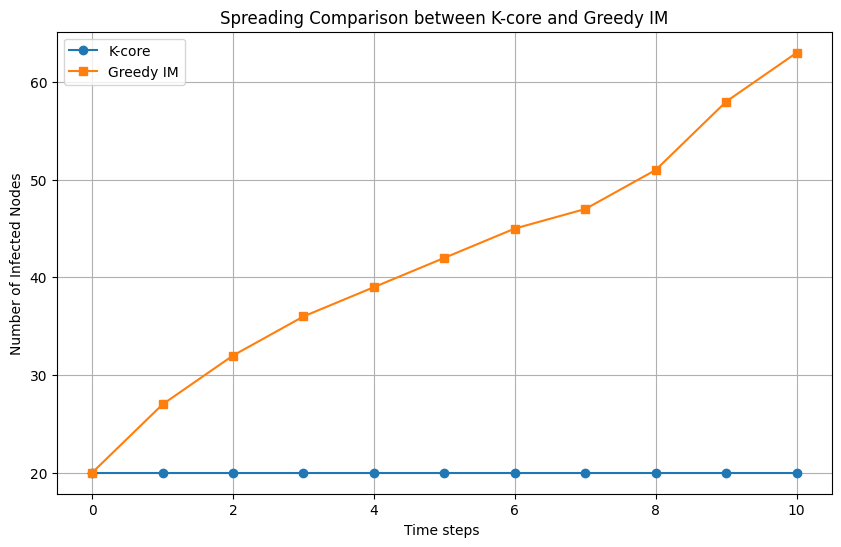

In [22]:
#plotting:
plt.figure(figsize = (10, 6))
plt.plot(kcore_spread, label = 'K-core', marker = 'o')
plt.plot(greedy_algo_spread, label = 'Greedy IM', marker ='s')
plt.xlabel('Time steps ')
plt.ylabel('Number of Infected Nodes')
plt.title('Spreading Comparison between K-core and Greedy IM')
plt.legend()
plt.grid(True)
plt.show()